#### Install Required Packages

In [487]:
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


#### Exploratary Data Analysis : UK Demand Data
Inspect UK demand data


In [488]:
import pandas as pd

df_demand = pd.read_csv('uk_demand_data.csv')

# Inspect data
display(df_demand.shape)
display(df_demand.head())
display(df_demand.dtypes)
display(df_demand.isnull().any())

(96, 11)

,date,electricity_generation,domestic,industrial,services,producer_own_use,operator_own_use,lng_own_use,storage_own_use,others,demand
0,Q1 2001,82019.0,154586.0,61949.0,37626.0,20415.0,2248.0,0.0,0.0,15383.0,374226.0
1,Q2 2001,78583.0,69547.0,43106.0,25028.0,19250.0,1327.0,0.0,0.0,10976.0,247817.0
2,Q3 2001,72592.0,35197.0,32242.0,15464.0,17828.0,844.0,0.0,0.0,9996.0,184163.0
3,Q4 2001,79324.0,120097.0,42442.0,34992.0,20964.0,2130.0,0.0,0.0,13706.0,313655.0
4,Q1 2002,82446.0,148988.0,52670.0,35837.0,20727.0,2287.0,0.0,0.0,13790.0,356745.0


date                       object
electricity_generation    float64
domestic                  float64
industrial                float64
services                  float64
producer_own_use          float64
operator_own_use          float64
lng_own_use               float64
storage_own_use           float64
others                    float64
demand                    float64
dtype: object

date                      False
electricity_generation    False
domestic                  False
industrial                False
services                  False
producer_own_use          False
operator_own_use          False
lng_own_use               False
storage_own_use           False
others                    False
demand                    False
dtype: bool

Timestamp Conversion

In [489]:
df_demand['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_demand['date']])
df_demand.head()

C:\Users\benja\AppData\Local\Temp\ipykernel_36832\3809532416.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_demand['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_demand['date']])


,date,electricity_generation,domestic,industrial,services,producer_own_use,operator_own_use,lng_own_use,storage_own_use,others,demand
0,2001-01-01,82019.0,154586.0,61949.0,37626.0,20415.0,2248.0,0.0,0.0,15383.0,374226.0
1,2001-04-01,78583.0,69547.0,43106.0,25028.0,19250.0,1327.0,0.0,0.0,10976.0,247817.0
2,2001-07-01,72592.0,35197.0,32242.0,15464.0,17828.0,844.0,0.0,0.0,9996.0,184163.0
3,2001-10-01,79324.0,120097.0,42442.0,34992.0,20964.0,2130.0,0.0,0.0,13706.0,313655.0
4,2002-01-01,82446.0,148988.0,52670.0,35837.0,20727.0,2287.0,0.0,0.0,13790.0,356745.0


Quarterly data is published on via multiple sectors

In [490]:
df_demand_final = pd.DataFrame()
df_demand_final['date'] = df_demand['date']
df_demand_final['domestic+commercial'] = df_demand['domestic'] + df_demand['services']
df_demand_final['industrial+others'] = df_demand['industrial'] + df_demand['lng_own_use'] + df_demand['operator_own_use'] + df_demand['others'] + df_demand['producer_own_use'] + df_demand['storage_own_use']
df_demand_final['elec'] = df_demand['electricity_generation']
df_demand_final['total'] = df_demand['demand']

display(df_demand_final.head())

,date,domestic+commercial,industrial+others,elec,total
0,2001-01-01,192212.0,99995.0,82019.0,374226.0
1,2001-04-01,94575.0,74659.0,78583.0,247817.0
2,2001-07-01,50661.0,60910.0,72592.0,184163.0
3,2001-10-01,155089.0,79242.0,79324.0,313655.0
4,2002-01-01,184825.0,89474.0,82446.0,356745.0


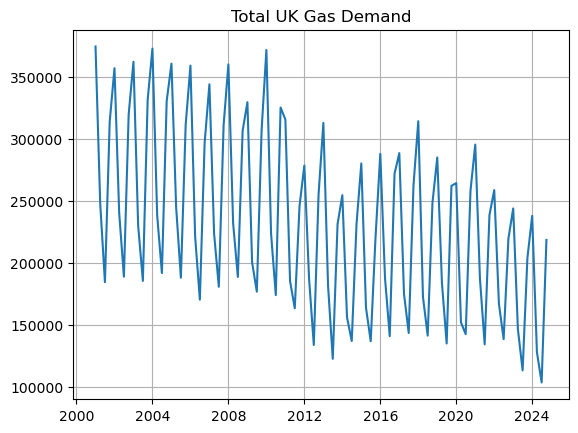

In [491]:
fig, ax = plt.subplots()
ax.plot(df_demand_final['date'], df_demand_final['total'])
ax.set_title('Total UK Gas Demand')
ax.grid(True)

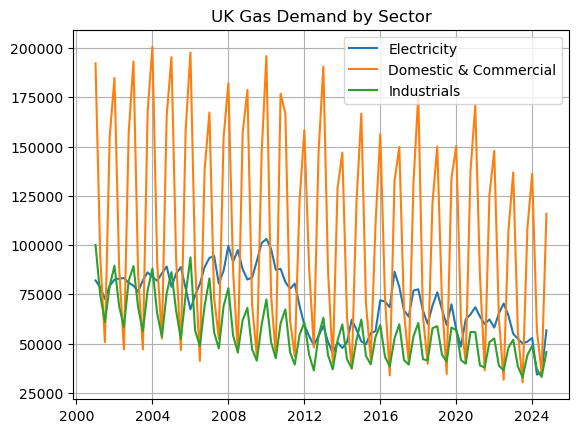

In [492]:
fig, ax = plt.subplots()
ax.plot(df_demand_final['date'], df_demand_final['elec'], label='Electricity')
ax.plot(df_demand_final['date'], df_demand_final['domestic+commercial'], label='Domestic & Commercial')
ax.plot(df_demand_final['date'], df_demand_final['industrial+others'], label='Industrials')
ax.set_title('UK Gas Demand by Sector')
ax.legend()
ax.grid(True)

#### External Regressor Data: EDA

In [493]:
df_weather = pd.read_csv('uk_weather_data.csv')
display(df_weather.shape)
display(df_weather.head())
display(df_weather.dtypes)
display(df_weather.isnull().any())

(96, 6)

,date,rainfall,sunhours,windspeed,temperature,heating_degree_days
0,Q1 2001,249.248935,2.832804,8.794621,4.714601,8.535148
1,Q2 2001,178.485001,6.452538,8.241631,11.421111,3.693704
2,Q3 2001,315.903293,5.462755,7.766157,15.850138,0.649218
3,Q4 2001,386.582732,2.790973,9.458103,8.534337,7.166271
4,Q1 2002,520.000982,2.735623,11.577786,6.979438,8.535148


date                    object
rainfall               float64
sunhours               float64
windspeed              float64
temperature            float64
heating_degree_days    float64
dtype: object

date                   False
rainfall               False
sunhours               False
windspeed              False
temperature            False
heating_degree_days    False
dtype: bool

In [494]:
df_weather['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_weather['date']])

C:\Users\benja\AppData\Local\Temp\ipykernel_36832\1204060040.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_weather['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_weather['date']])


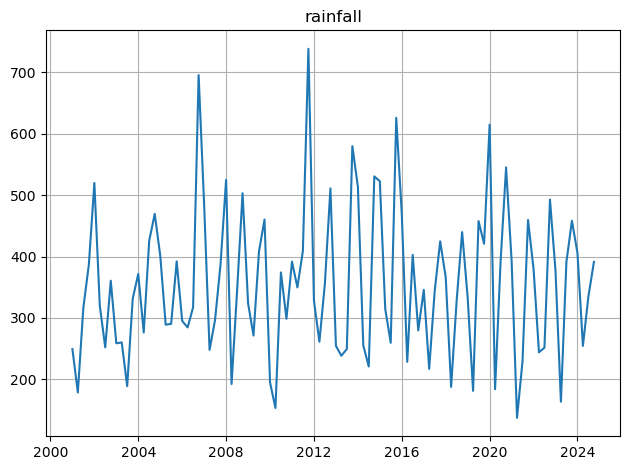

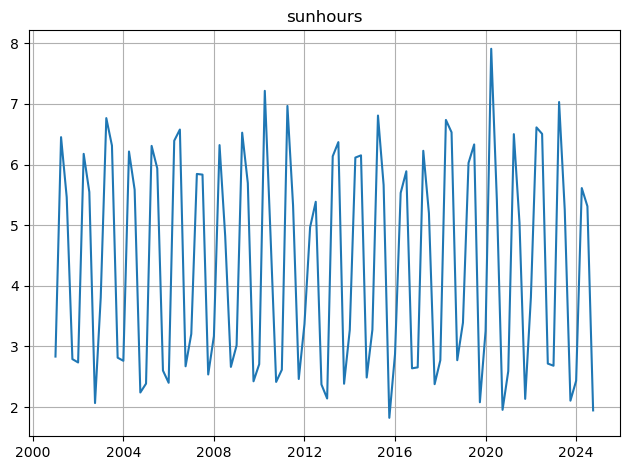

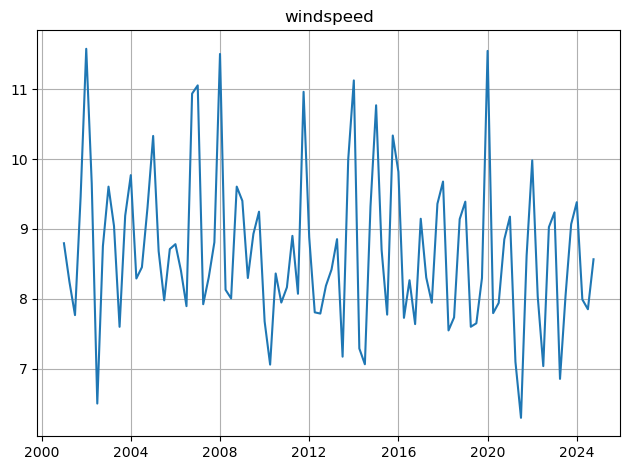

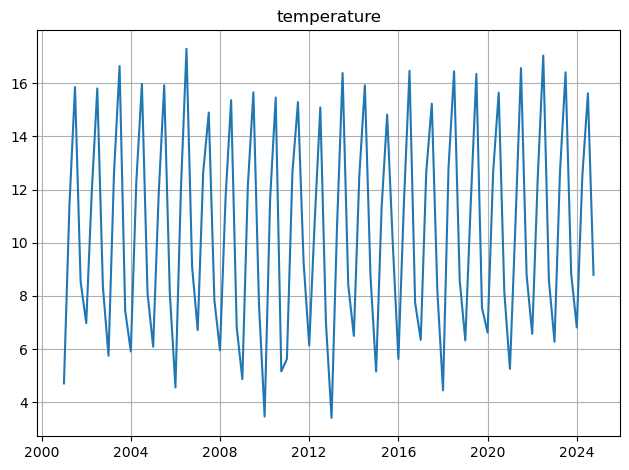

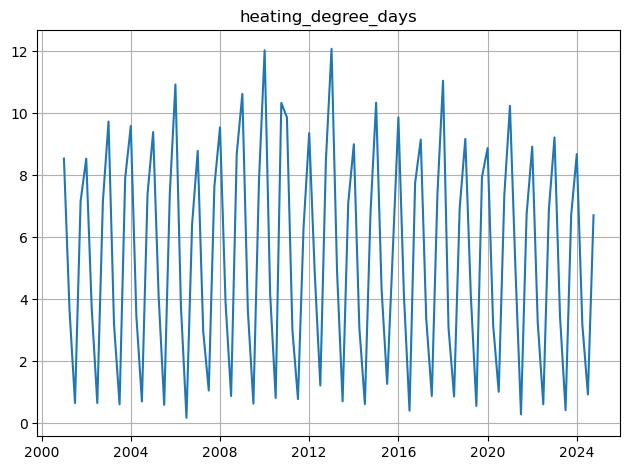

In [495]:
for i in df_weather.loc[:, df_weather.columns != 'date'].columns:
    plt.figure()
    plt.plot(df_weather['date'], df_weather[i])
    plt.title(i)
    plt.tight_layout()
    plt.grid(True)



#### UK Indices Data: EDA

In [496]:
df_indices = pd.read_csv('uk_indices_data.csv')
display(df_indices.shape)
display(df_indices.head())
display(df_indices.dtypes)
display(df_indices.isnull().any())

(96, 4)

,date,domestic_price,industrial_price,gdp
0,Q1 2001,50.659417,63.146926,457680
1,Q2 2001,52.133440,61.809519,459620
2,Q3 2001,52.296868,57.709785,462016
3,Q4 2001,52.465025,65.499853,463404
4,Q1 2002,54.150954,67.806783,464698


date                 object
domestic_price      float64
industrial_price    float64
gdp                   int64
dtype: object

date                False
domestic_price      False
industrial_price    False
gdp                 False
dtype: bool

In [497]:
df_indices['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_indices['date']])

C:\Users\benja\AppData\Local\Temp\ipykernel_36832\3361329138.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_indices['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df_indices['date']])


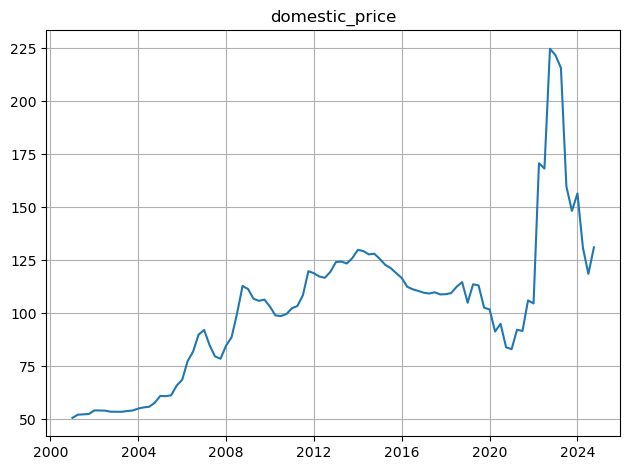

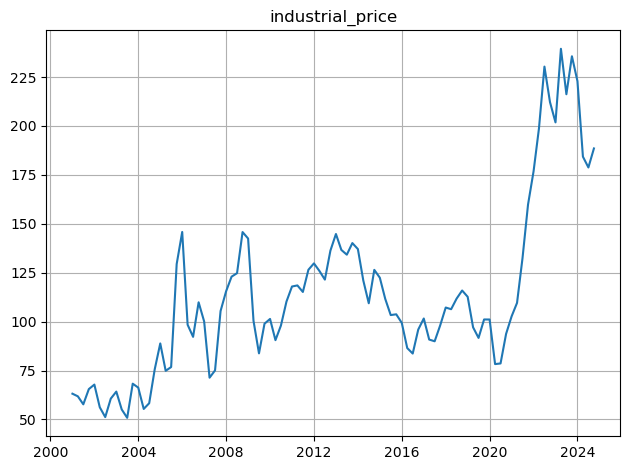

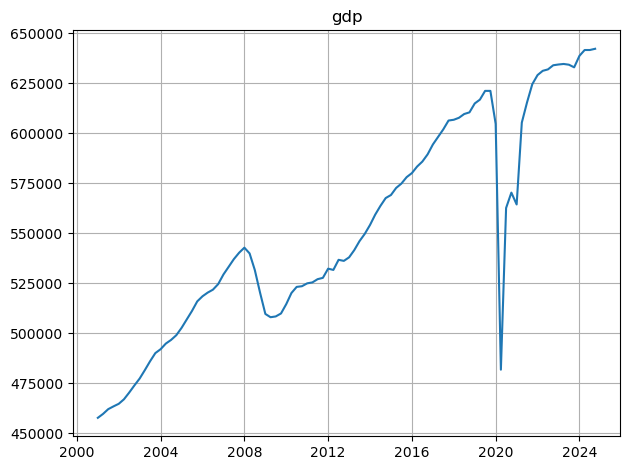

In [498]:
for i in df_indices.loc[:, df_indices.columns != 'date'].columns:
    plt.figure()
    plt.plot(df_indices['date'], df_indices[i])
    plt.title(i)
    plt.tight_layout()
    plt.grid(True)


#### Modelling
Let's first start modelling without regressors

In [499]:
df = df_demand_final[['date','total']]
df = df.rename(columns={'date':'ds', 'total':'y'})


df_train = df[df['ds'] < pd.Timestamp('2022-01-01')]
df_test = df[df['ds'] >= pd.Timestamp('2022-01-01')]

print(f'# of training sets: {len(df_train)}')
print(f'# of test sets: {len(df_test)}')


# of training sets: 84
# of test sets: 12


In [500]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='additive')
model.add_seasonality('quarter', period=365/4, fourier_order=10, prior_scale=5)
model.fit(df_train)

00:10:33 - cmdstanpy - INFO - Chain [1] start processing
00:10:33 - cmdstanpy - INFO - Chain [1] done processing


In [501]:
df_future = model.make_future_dataframe(periods=12, freq='QS')
df_future.tail()

,ds
91,2023-10-01
92,2024-01-01
93,2024-04-01
94,2024-07-01
95,2024-10-01


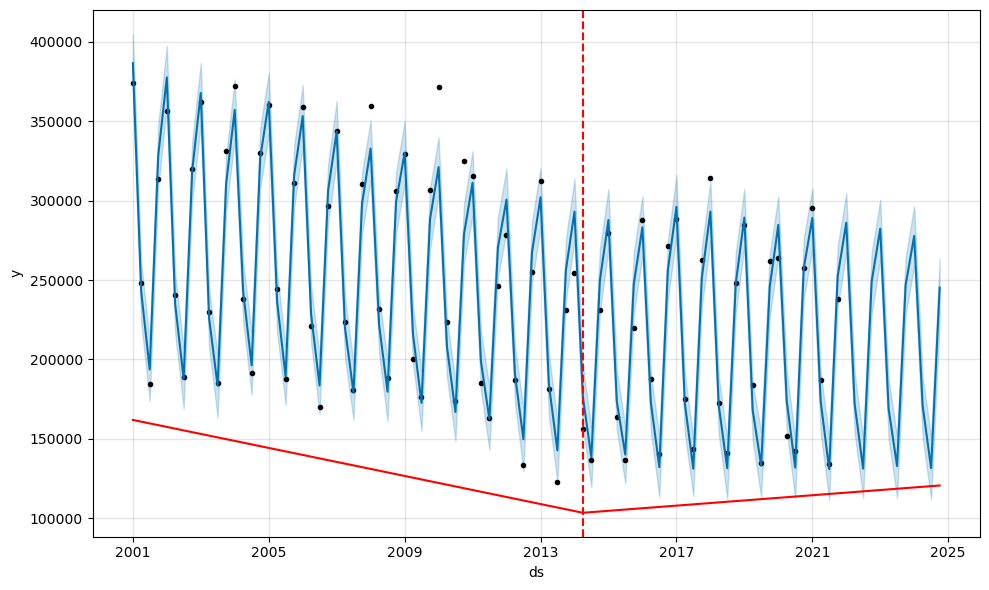

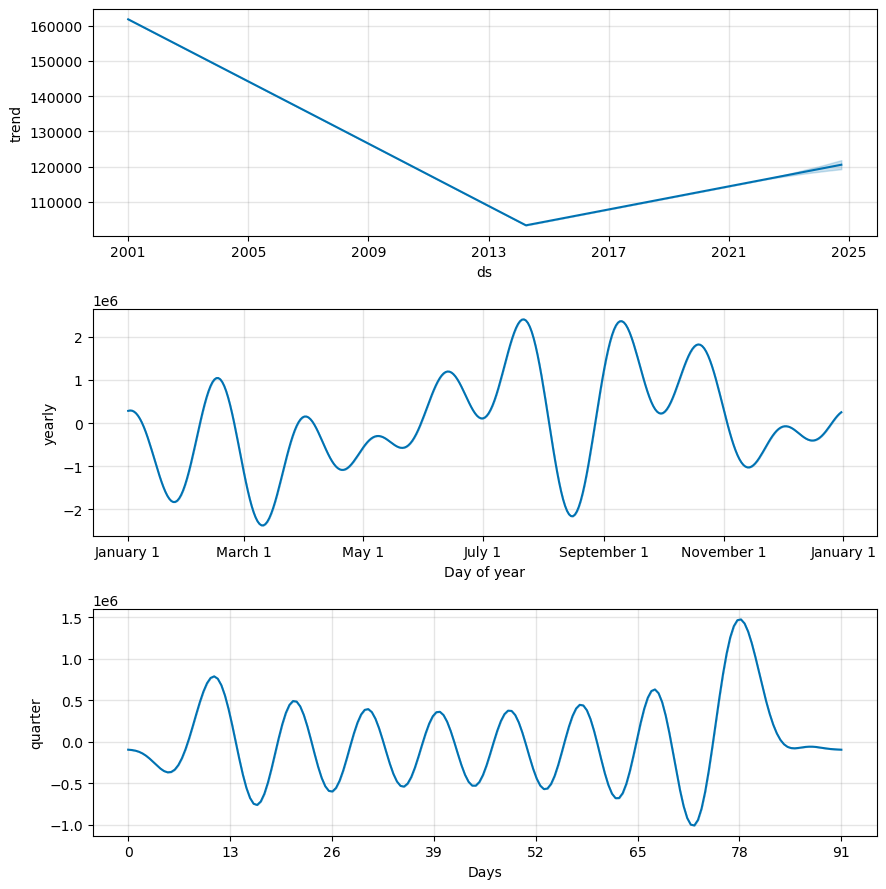

In [502]:
forecast = model.predict(df_future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig = model.plot_components(forecast)

In [503]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,quarter,quarter_lower,quarter_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,161820.561564,367242.175902,405055.081296,161820.561564,161820.561564,224855.923684,224855.923684,224855.923684,-57379.538356,-57379.538356,-57379.538356,282235.462040,282235.462040,282235.462040,0.0,0.0,0.0,386676.485248
1,2001-04-01,160733.755037,222718.016992,260826.622987,160733.755037,160733.755037,81635.313399,81635.313399,81635.313399,-69748.003153,-69748.003153,-69748.003153,151383.316552,151383.316552,151383.316552,0.0,0.0,0.0,242369.068436
2,2001-07-01,159634.872882,173712.129601,211745.644000,159634.872882,159634.872882,33935.049157,33935.049157,33935.049157,-73267.576472,-73267.576472,-73267.576472,107202.625629,107202.625629,107202.625629,0.0,0.0,0.0,193569.922039
3,2001-10-01,158523.915099,308638.815115,348239.167597,158523.915099,158523.915099,170026.921845,170026.921845,170026.921845,-62696.799764,-62696.799764,-62696.799764,232723.721609,232723.721609,232723.721609,0.0,0.0,0.0,328550.836945
4,2002-01-01,157412.957316,359004.440049,397605.143415,157412.957316,157412.957316,220259.479495,220259.479495,220259.479495,-57379.538356,-57379.538356,-57379.538356,277639.017852,277639.017852,277639.017852,0.0,0.0,0.0,377672.436811


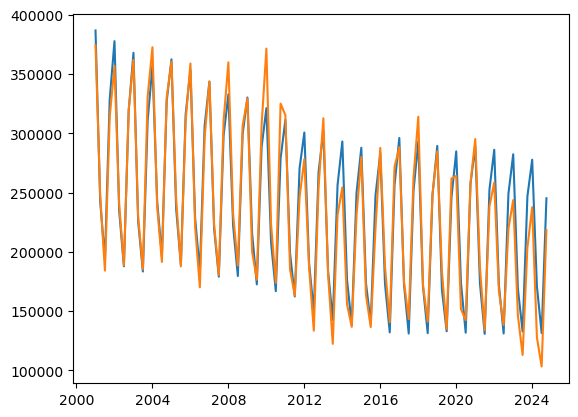

In [504]:
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.plot(df['ds'], df['y'], label='training')
plt.legend=True

MAE: 27610.90
MAPE: 0.16
MSE: 910008871.62
r2: 0.67


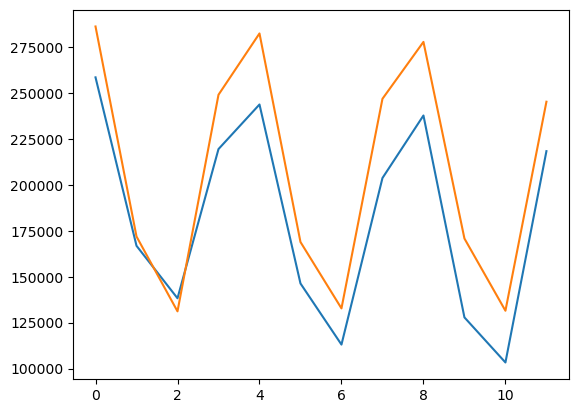

In [505]:
y_true = df_test['y'].values
y_best = forecast['yhat'][-12:].values

mae = mean_absolute_error(y_true, y_best)
print('MAE: %.2f' % mae)

mape = mean_absolute_percentage_error(y_true, y_best)
print('MAPE: %.2f' % mape)

mse = mean_squared_error(y_true, y_best)
print('MSE: %.2f' %mse)

r2 = r2_score(y_true, y_best)
print('r2: %.2f' % r2)

plt.plot(y_true)
plt.plot(y_best)


Let's add regressors

In [506]:
df = pd.merge(df, df_weather[['date','temperature']], left_on='ds', right_on='date')
df = df.drop(['date'], axis=1)
df = pd.merge(df, df_indices[['date','industrial_price','domestic_price']], left_on='ds', right_on='date')
df = df.drop(['date'], axis=1)
df

,ds,y,temperature,industrial_price,domestic_price
0,2001-01-01,374226.00,4.714601,63.146926,50.659417
1,2001-04-01,247817.00,11.421111,61.809519,52.133440
2,2001-07-01,184163.00,15.850138,57.709785,52.296868
3,2001-10-01,313655.00,8.534337,65.499853,52.465025
4,2002-01-01,356745.00,6.979438,67.806783,54.150954
...,...,...,...,...,...
91,2023-10-01,203660.51,8.847127,235.610007,148.247093
92,2024-01-01,237674.16,6.818524,222.860382,156.467156
93,2024-04-01,127848.87,12.513213,184.296719,130.877542
94,2024-07-01,103329.07,15.614907,178.765668,118.535679


In [ ]:
df_train = df[df['ds'] < pd.Timestamp('2022-01-01')]
df_test = df[df['ds'] >= pd.Timestamp('2022-01-01')]


model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='additive')
model.add_seasonality('quarter', period=365/4, fourier_order=10, prior_scale=5)
#model.add_regressor('rainfall', mode='multiplicative')
#model.add_regressor('sunhours', mode='multiplicative')
#model.add_regressor('windspeed', mode='multiplicative')
model.add_regressor('temperature', mode='additive')
#model.add_regressor('heating_degree_days', mode='multiplicative')
#model.add_regressor('industrial_price', mode='additive')
model.add_regressor('domestic_price', mode='additive')
#model.add_regressor('gdp', mode='multiplicative')

model.fit(df_train)


00:10:34 - cmdstanpy - INFO - Chain [1] start processing
00:10:35 - cmdstanpy - INFO - Chain [1] done processing


In [508]:
df_future = model.make_future_dataframe(periods=12, freq='QS')
df_future = pd.merge(df_future, df_weather[['date','temperature']], left_on='ds', right_on='date')
df_future = df_future.drop(['date'], axis=1)
df_future = pd.merge(df_future, df_indices[['date','industrial_price','domestic_price']], left_on='ds', right_on='date')
df_future = df_future.drop(['date'], axis=1)
df_future

,ds,temperature,industrial_price,domestic_price
0,2001-01-01,4.714601,63.146926,50.659417
1,2001-04-01,11.421111,61.809519,52.133440
2,2001-07-01,15.850138,57.709785,52.296868
3,2001-10-01,8.534337,65.499853,52.465025
4,2002-01-01,6.979438,67.806783,54.150954
...,...,...,...,...
91,2023-10-01,8.847127,235.610007,148.247093
92,2024-01-01,6.818524,222.860382,156.467156
93,2024-04-01,12.513213,184.296719,130.877542
94,2024-07-01,15.614907,178.765668,118.535679


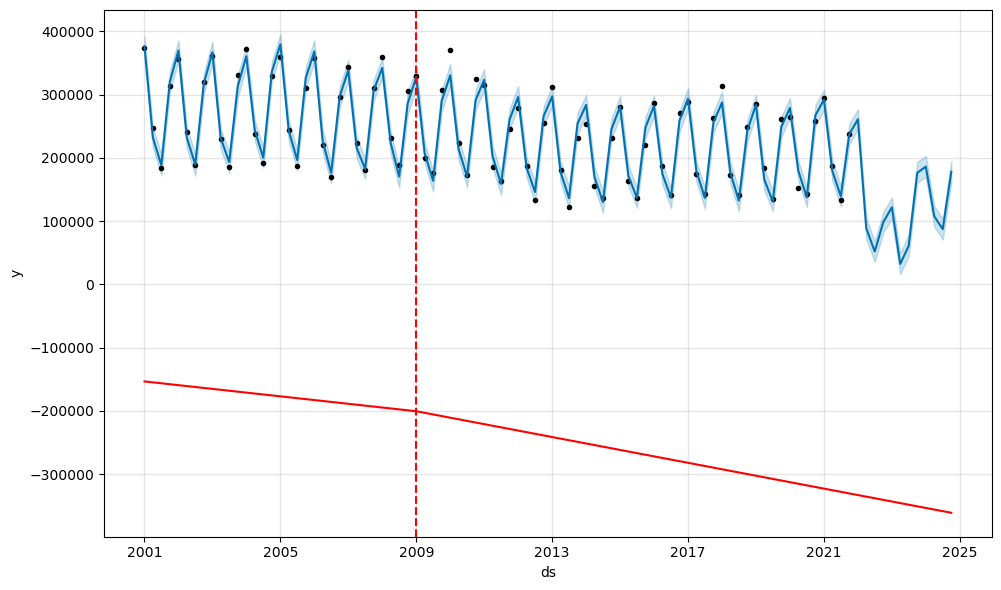

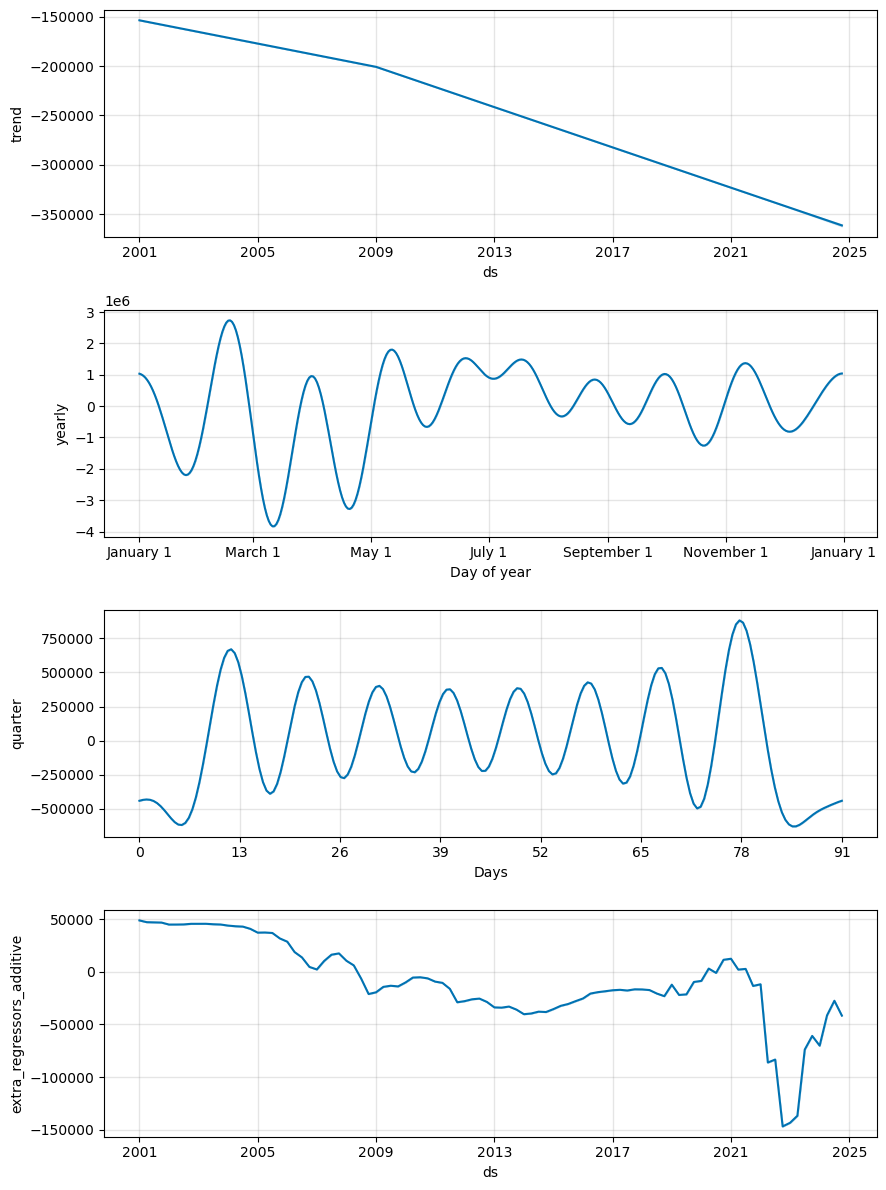

In [509]:
forecast = model.predict(df_future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig = model.plot_components(forecast)

MAE: 60947.04
MAPE: 0.35
MSE: 5370050501.75
r2: -0.94


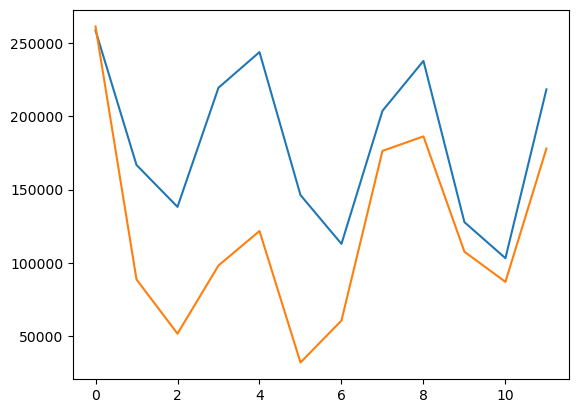

In [510]:
y_true = df_test['y'].values
y_best = forecast['yhat'][-12:].values

mae = mean_absolute_error(y_true, y_best)
print('MAE: %.2f' % mae)

mape = mean_absolute_percentage_error(y_true, y_best)
print('MAPE: %.2f' % mape)

mse = mean_squared_error(y_true, y_best)
print('MSE: %.2f' %mse)

r2 = r2_score(y_true, y_best)
print('r2: %.2f' % r2)

plt.plot(y_true)
plt.plot(y_best)